<h1>Predicting the stock market with Machine Learning</h1>

<p>Machines are becoming increasingly prevalent in the financial sector. Right now, it is estimated that 90% of trades done on Wall Street are performed by automated trading systems. That is a startlingly high number, but it becomes unsurprising when you consider the benefits granted by such systems: </p>
<ul>
   <li>Computers can perform calculations millions of times faster than any human, allowing them to exploit technical indicators to their full potential.</li>
    <li>They can execute trades down to the nanosecond, ensuring that they obtain the optimal positions for maximum profit.</li> 
    <li>Most importantly of all, they are able to remove the emotional aspect of trading. There is no danger of making poor decisions due to greed or fear, because machines aren't able to feel anything.</li>
        <li>Instead, they follow a strict set of rules and guidelines, never deviating from their core algorithims, allowing for a remarkably consistent approach to trading. </li>
  </ul>  
<p>It is every programmer's dream to design a robot that can be profitable on the market all on its own, without any human intervention. To an extent, this has been achieved in large firms where they have the resources to build the fastest computers that can perform calculations and execute trades down to the nanoseconds, as well as decades of research optimizing their algorithims. </p>
<p>As a beginner to both Machine Learning and the financial markets, I intend to answer some questions I have relating to the markets, explore the efficacy of certain indicators, and attempt to design a machine that is able to be somewhat profitable, at least in a virtual environment.</p>


In [ ]:
'''
 ##### Problem Statement and Dataset Selected #####


*********** Why is this of interest to me? ***********

- Recently began investing, been overwhelmed by the deluge of new tools and jargon used by pundits. Working on 
this project may help me better understand the investing landscape

- Ability to incorporate multiple skills acquired from this course (data manipulation, graphing,
web scraping etc.) into one project and be exposed to advanced concepts in machine learning (eg. RNNs, LSTMs etc. )
via high level libraries like Keras

- Possible monetary rewards :)

*********** Which dataset did I use for this project? ***********

A New York Stock Exchange dataset (CSV) containing historical prices for S&P 500 companies from 2012-2016. 

Various webscraped datasets from different news/stocks websites. 


    -
'''

<h1>SECTION 1: Sentiment Analysis on Financial News</h1>
<p>It is no secret that the stock market is a place dominated not by reason but by investor sentiment. In a way, this makes
sense, since  no one can predict with certainty the performance of any one company over many months/years, so this leaves 
investors to speculate on a stock's actual value, adjusting and correcting whenever new information emerges that 
shakes the public opinion. The rationale of this section is to capture that sentiment and use it to make predictions on how 
the market will move the following day.</p>

In [ ]:
### IMPORTED LIBRARIES ###

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select
import time
from bs4 import BeautifulSoup
import pandas as pd
import re
import datetime
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stemmer = PorterStemmer()
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
STOPWORDS = stopwords.words()
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from google.api_core.protobuf_helpers import get_messages
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
sid = SentimentIntensityAnalyzer()
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
### 1. Webscraping online data for analysis ###

### IDEA 1: USING GOOGLE SEARCHES BY DATE TO FIND FINANCIAL NEWS ###
def google_scrape(stock, datelist):
    try:
        
        date_col = []
        info_col = []
        stock_col = []
        
        driver = webdriver.Chrome(r'C:\Programming\webdrivers\chromedriver')
        driver.implicitly_wait(15)
        driver.get('https://www.google.com/')
        searchbar = driver.find_element_by_name('q')
        searchbar.send_keys(stock)
        searchbar.send_keys(Keys.RETURN)
        
        for k, date in enumerate(datelist):
            real_date = date.strftime("%m/%d/%Y")
            if k == 0:
                
                tools = driver.find_element_by_id('hdtb-tls')
                tools.click()
            
            
            date_range = driver.find_element_by_class_name('mn-hd-txt')
            ActionChains(driver).move_to_element(date_range).perform()
            date_range.click()

            custom = driver.find_element_by_id('cdrlnk').click()

            min_date = driver.find_element_by_id("cdr_min")
            min_date.clear()
            min_date.click()
            min_date.send_keys(Keys.HOME)
            min_date.send_keys(real_date)


            max_date = driver.find_element_by_id("cdr_max")
            max_date.clear()
            max_date.click()
            max_date.send_keys(Keys.HOME)
            max_date.send_keys(real_date)
            max_date.send_keys(Keys.RETURN)

            headlines = driver.find_elements_by_class_name("ellip")
            websites = driver.find_elements_by_class_name('iUh30')
            
            for j, hl in enumerate(headlines):
                hl_text = BeautifulSoup(hl.get_attribute('outerHTML')).text
                try:
                    ws_text = BeautifulSoup(websites[j].get_attribute('outerHTML')).text.split()[0]
                except:
                    ws_text = ""
                final_text = hl_text + ' ' + ws_text
                date_col.append(date)
                info_col.append(final_text)
                stock_col.append(stock)
                
        spreadsheet = pd.DataFrame({'Date':date_col, 'Info':info_col, 'Stock':stock_col})
        spreadsheet.to_excel(stock+'_infosheet.xlsx')
        
 
    finally:
        time.sleep(2)
        driver.quit()

        
base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(150)]


google_scrape('APPL', date_list)        

### CONCLUSION - IDEA ABANDONED ###
### The search results often had nothing to do with financial news, even when using the company's stock name.
### Such information would only serve as noise in any potential model of the financial markets. I made the executive 
### decision to abandon this idea. 



In [20]:
### IDEA 2: Scraping from Financial News Websites ###

### The rationale is that websites like CNBC and Buisness Times, being highly focused, would provide a better basis to 
### provide predictions on the stock market. Unlike Google, these websites do not have an option to search by date, only 
### by most recent, which ranges from 2018-2019. This makes my historical data obsolete, so I need to scrape more recent data
### from the NASDAQ website instead. 

### Getting recent data from NASDAQ website (Apple) ###
def hist_data(stock):
    
    driver = webdriver.Chrome(r'C:\Programming\webdrivers\chromedriver')
    driver.implicitly_wait(15)
    driver.get(f'https://www.nasdaq.com/market-activity/stocks/{stock}/historical/')
    fkoff = driver.find_element_by_class_name('eu-cookie-compliance-default-button').click()
    six_months = driver.find_elements_by_class_name('table-tabs__tab')[1]
    ActionChains(driver).move_to_element(six_months).perform()
    time.sleep(2)
    six_months.click()
    time.sleep(2)
    num_pages = len(driver.find_elements_by_class_name('pagination__page'))
   
    print(num_pages)
 
    j = 0
    stonks = None
    while j<num_pages:
       
        next_btn = driver.find_element_by_class_name('pagination__next')
        ActionChains(driver).move_to_element(next_btn).perform()
        next_btn.click()
        
        hist_data = driver.find_element_by_class_name('historical-data__table')
        hist_df = pd.read_html(hist_data.get_attribute('outerHTML'))[0]
        print(hist_df.head())
        if j == 0:
            stonks = hist_df
        else:
            stonks = pd.concat([stonks, hist_df])
           
        j+=1
        time.sleep(3)

    return stonks

stonks = hist_data('aapl')
stonks.head()


8
         Date Close/Last    Volume     Open     High       Low
0  09/23/2019    $218.72  19419650  $218.95  $219.84   $217.65
1  09/20/2019    $217.73  57977090  $221.38  $222.56  $217.473
2  09/19/2019    $220.96  22187880  $222.01  $223.76   $220.37
3  09/18/2019    $222.77  25643090  $221.06  $222.85   $219.44
4  09/17/2019     $220.7  18386470  $219.96  $220.82   $219.12
         Date Close/Last    Volume     Open      High        Low
0  08/27/2019    $204.16  25897340  $207.86   $208.55    $203.53
1  08/26/2019    $206.49  26066130  $205.86   $207.19  $205.0573
2  08/23/2019    $202.64  46882840  $209.43  $212.051       $201
3  08/22/2019    $212.46  22267820  $213.19  $214.435    $210.75
4  08/21/2019    $212.64  21564750  $212.99   $213.65  $211.6032
         Date Close/Last    Volume     Open     High        Low
0  08/01/2019    $208.43  54017920   $213.9  $218.03  $206.7435
1  07/31/2019    $213.04  69281360  $216.42  $221.37     $211.3
2  07/30/2019    $208.78  33935720  $2

,Date,Close/Last,Volume,Open,High,Low
0,09/23/2019,$218.72,19419650,$218.95,$219.84,$217.65
1,09/20/2019,$217.73,57977090,$221.38,$222.56,$217.473
2,09/19/2019,$220.96,22187880,$222.01,$223.76,$220.37
3,09/18/2019,$222.77,25643090,$221.06,$222.85,$219.44
4,09/17/2019,$220.7,18386470,$219.96,$220.82,$219.12


<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 0 to 0
Data columns (total 6 columns):
Date          127 non-null datetime64[ns]
Close/Last    127 non-null float64
Volume        127 non-null int64
Open          127 non-null float64
High          127 non-null float64
Low           127 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 6.9 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 0 to 0
Data columns (total 6 columns):
Date          127 non-null datetime64[ns]
Close/Last    127 non-null float64
Volume        127 non-null int64
Open          127 non-null float64
High          127 non-null float64
Low           127 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 6.9 KB
None


Text(0.5, 1.0, 'Apple Closing Stock Price Over Time')

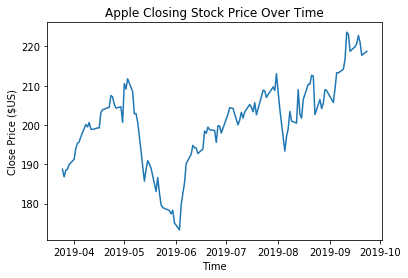

In [35]:
### Cleaning the NASDAQ dataset ###
print(stonks.info()) ## no null, but need to change dtypes

##Change date strings to datetime format 
def convert_to_date(date):
    return date.replace('/', '-')

def convert_mones_to_float(mone):
    return float(mone[1:])

from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

def clean_dataset(stonks):
    stonks['Date'] = stonks['Date'].apply(convert_to_date)
    stonks['Date'] = stonks['Date'].astype('datetime64[ns]')
    stonks['Close/Last'] = stonks['Close/Last'].apply(convert_mones_to_float)
    stonks['Open'] = stonks['Open'].apply(convert_mones_to_float)
    stonks['High'] = stonks['High'].apply(convert_mones_to_float)
    stonks['Low'] = stonks['Low'].apply(convert_mones_to_float)
    

#clean_dataset(stonks)

print(stonks.info())

plt.plot(stonks['Date'], stonks['Close/Last'])
plt.ylabel('Close Price ($US)')
plt.xlabel('Time')
plt.title('Apple Closing Stock Price Over Time')

In [275]:
### Getting news articles and their contents from CNBC ###
### WARNING: DO NOT RUN TO COMPLETION. I SCRAPED 200+ articles from CNBC ###
import time
import datetime
def scrape_from_cnbc(stock):
    try:
         
        hl_col = []
        info_col = []
        stock_col = []
        date_col = []
        fa_col = []
    
        
        driver = webdriver.Chrome(r'C:\Programming\webdrivers\chromedriver')
        driver.implicitly_wait(5)
        driver.get(f'https://www.cnbc.com/search/?query={stock}&qsearchterm=' )
        
        #scroll to get more results
        for i in range(3):
            SCROLL_PAUSE_TIME = 3
            last_height = driver.execute_script("return document.body.scrollHeight")

            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                # Wait to load page
            time.sleep(SCROLL_PAUSE_TIME)

                # Calculate new scroll height and compare with last scroll height
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                 break
            last_height = new_height
            
      
 
       
        containers = driver.find_elements_by_class_name("SearchResult-searchResultContent")
      
        main_window = driver.current_window_handle
        
        #Get 150 headlines
        for j, container in enumerate(containers):
            if j == 2000:
                break
            soup =  BeautifulSoup(container.get_attribute('outerHTML'))

            try:
                hl_text = soup.find('span',attrs={'class':"Card-title"}).text
            except:
                hl_text = ""
            try:
                ws_text = soup.find('p',attrs={'class':"SearchResult-searchResultPreview"}).text
            except:
                ws_text = ""
            try:
                ar_date = soup.find('span',attrs={'class':"SearchResult-publishedDate"}).text
              
                ar_date = ar_date.split()[0]
                ar_date = datetime.datetime.strptime(ar_date, '%m/%d/%Y')
              
            except:
                print('Date failed')
                ar_date = None
    
            hl_col.append(hl_text)
            info_col.append(ws_text)
            stock_col.append(stock)
            date_col.append(ar_date)
            
            newurl = soup.find('a',attrs={'class':"resultlink"})['href']
            driver.execute_script("window.open('');")
            driver.switch_to_window(driver.window_handles[1])
            driver.get(newurl)
            try:
                all_p = driver.find_elements_by_css_selector('.group p')
            
      
                textual = [BeautifulSoup(para.get_attribute('outerHTML')).text for para in all_p]
                article = ' '.join(textual)

            except:
                article=""
        
            fa_col.append(article)
            
            driver.close()
            driver.switch_to_window(main_window)
            
            print(j)
        spreadsheet = pd.DataFrame({ 'Headline':hl_col, 'Info':info_col, 'Stock':stock_col, 'Date':date_col, 'Full':fa_col})
        spreadsheet.to_excel(stock+'2'+'_infosheet.xlsx')

 
    finally:
        time.sleep(2)
        driver.quit()
        
stockups = ['Apple']# 'Google', 'Tesla', 'Facebook', 'Microsoft', 'Starbucks', 'Zynga', 'Amazon']

for astock in stockups:
    scrape_from_cnbc(astock)        


C:\Users\Edison Siow Xiong\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:72: DeprecationWarning: use driver.switch_to.window instead
C:\Users\Edison Siow Xiong\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:87: DeprecationWarning: use driver.switch_to.window instead


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189


In [268]:
### Getting news articles and their contents from Business Times ###


def scrape_from_business_times(stock):
    try:
         
        hl_col = []
       
        stock_col = []
        date_col = []
        fa_col = []
    
        
        driver = webdriver.Chrome(r'C:\Programming\webdrivers\chromedriver')
        driver.implicitly_wait(5)
        driver.get(f'https://www.businesstimes.com.sg/search/{stock}?page=1&filter=headline_en' )
        pages = driver.find_elements_by_css_selector('.pagination li')     
        print(len(pages))
        for k in range (len(pages)):
            
       
            containers = driver.find_elements_by_class_name("media-body")

            main_window = driver.current_window_handle


            for j, container in enumerate(containers):
                soup =  BeautifulSoup(container.get_attribute('outerHTML'))

                try:
                    hl_text = soup.find('a').text
                except:
                    hl_text = ""

                try:
                    ar_date = soup.find('time').text
                    ar_date = datetime.datetime.strptime(ar_date, '%d %B %Y')
                except:
                    ar_date = None

                hl_col.append(hl_text)
                stock_col.append(stock)
                date_col.append(ar_date)

                newurl = soup.find('a')['href']
                driver.execute_script("window.open('');")
                print(newurl)
                driver.switch_to_window(driver.window_handles[1])
                driver.get(newurl)
                try:
                    all_p = driver.find_elements_by_css_selector('.field-type-text-with-summary p')


                    textual = [BeautifulSoup(para.get_attribute('outerHTML')).text for para in all_p]
                    article = ' '.join(textual)

                except:
                    article=""

                fa_col.append(article)

                driver.close()
                driver.switch_to_window(main_window)
            
            if k == 9:
                break
            pages = driver.find_elements_by_css_selector('.pagination li')     
            eggshell = BeautifulSoup(pages[k+1].get_attribute('outerHTML'))
            newpage = eggshell.find('a')['href']
            driver.get(f'https://www.businesstimes.com.sg' + newpage)
            time.sleep(3)
            

        spreadsheet = pd.DataFrame({ 'Headline':hl_col, 'Stock':stock_col, 'Date':date_col, 'Full':fa_col})
        spreadsheet.to_excel(stock+'2 BT'+'_infosheet.xlsx')

 
    finally:
        time.sleep(2)
        driver.quit()
        
stockups = ['Apple']# 'Google', 'Tesla', 'Facebook', 'Microsoft', 'Starbucks', 'Zynga', 'Amazon']

for astock in stockups:
    scrape_from_business_times(astock)      

10
https://www.businesstimes.com.sg/technology/google-takes-on-apple-arcade-with-mobile-game-service


C:\Users\Edison Siow Xiong\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:47: DeprecationWarning: use driver.switch_to.window instead


WebDriverException: Message: chrome not reachable
  (Session info: chrome=76.0.3809.132)


In [16]:
### After scraping all these articles and saving them in spreadsheets, I performed sentiment analysis on them and added 
### the results to the webscraped NASDAQ data

def sentiment_analyzer(document):
    if pd.isnull(document):
        return None
    cleaned_doc = document.lower().strip()
    re.sub("[.®'&$’\"\-()]", "", cleaned_doc)
    tokenized = word_tokenize(cleaned_doc) 
    
    tagged = nltk.pos_tag(tokenized)
    lemmatized = []
    for pair in tagged:
        
        word, tag = pair
        try:
            lemmatized.append(lemmatizer.lemmatize(word, pos = tag[0].lower()))
        except KeyError:
            lemmatized.append(word)
        
   
    filtered=[]
    for word in lemmatized:
        if word not in STOPWORDS:
            filtered.append(word)
          
    ss = sid.polarity_scores(' '.join(filtered))
    return ss['compound']


### testing analyzer

sentiment_analyzer('''
[SAN FRANCISCO] Walt Disney Co Chief Executive Officer Bob Iger resigned from Apple Inc's board, a sign of increased competition between the entertainment and technology giants.

Apple said in a Friday regulatory filing that Mr Iger quit on Tuesday. He had served as a director since 2011 and was a friend of Steve Jobs. The Apple co-founder was also a Disney board member until he died in 2011. The duo appeared on stage more than a decade ago to announce an iTunes partnership.

The relationship between the two companies became more fraught after Apple expanded into original TV shows and movies, making the Cupertino, California-based company a potent new rival for Disney. That had put Mr Iger's role on Apple's board in doubt.

On Tuesday - the same day Mr Iger resigned from the board - Apple CEO Tim Cook said the company's TV+ service would launch Nov 1 for US$4.99 a month, undercutting the upcoming Disney+ offering. The announcement dented Disney shares.



In an April interview with Bloomberg TV, Mr Iger said he was careful to recuse himself at Apple board meetings whenever the topic of streaming video came up.

SEE ALSO: Japan's FTC investigating Apple over pressure on parts makers - Mainichi

He added that the topic "has not been discussed all that much" by the Apple directors, because it was relatively small and nascent. "So far it's been OK," he said. "I'm in constant discussion about it."

"It has been an extraordinary privilege to have served on the Apple board for eight years, and I have the utmost respect for Tim Cook, his team at Apple and for my fellow board members," Mr Iger said in an emailed statement.

His departure leaves Apple with seven board members. The average board has 10.8 directors, according to a 2018 analysis of companies in the S&P 500 index by Spencer Stuart, a consulting firm that provides executive search and board-related services.

BLOOMBERG

APPLE INCWALT DISNEY COBOB IGER
''')

### Gives a highly positive result - a dangerous sign

0.9153

                                            Headline  \
0  Apple named UK’s top tech employer, US firms d...   
1                    How to make Apple Card payments   
2  Disney CEO Bob Iger says he left Apple’s board...   
3  Here are the biggest analyst calls of the day:...   
4  A new Apple analyst just came out with a very ...   

                                                Info  Stock       Date  \
0  Apple has been named the best tech company to ...  Apple 2019-09-26   
1  The Apple Card launched in late August with a ...  Apple 2019-09-25   
2  Disney CEO Bob Iger left Apple’s board because...  Apple 2019-09-25   
3  Here are the biggest calls on Wall Street on T...  Apple 2019-09-24   
4  Wall Street’s estimates for the impact of 5G i...  Apple 2019-09-24   

                                                Full  
0  Apple has been named the best tech company to ...  
1  The Apple Card launched in late August with a ...  
2  Disney CEO Bob Iger left Apple’s board because... 

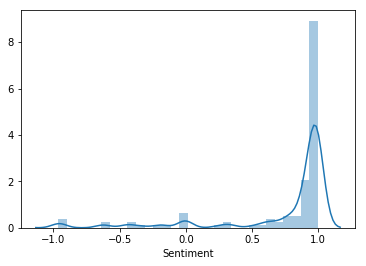

In [277]:
### Now adding sentiment and average sentiment column to our webscraped articles ###
com_ds = pd.read_excel('Apple2_infosheet.xlsx', index_col=0)
print(com_ds.head())
sentiment_col = com_ds['Full'].apply(sentiment_analyzer)
com_ds['Sentiment'] = sentiment_col


pure_com = com_ds.dropna(axis=0)

sns.distplot(pure_com['Sentiment'], bins=30)

av_senti_col = []
ud_col = []

### Finding average sentiment for each day ###
for ud in pure_com['Date'].unique():
    print(ud)
    av_senti = pure_com[pure_com['Date'] == ud]['Sentiment'].mean()
    av_senti_col.append(av_senti)
    ud_col.append(ud)

new_bt_com = pd.DataFrame({'Date':ud_col,'Average Sentiment':av_senti_col})

In [282]:
### The histogram above shows that the distribution of sentiments is incredibly skewed towards 1 
### with the Vader Sentiment Analyzer. This will likely prove unproductive in the future, as there cannot be a strong 
### correlation if all the sentiments are so similar, especially for a graph as volatile as Apple's as seen above 

### This is corroborated by the following correlation matrix, which finds low correlation between the sentiments of the
### previous day and an increase/decrease, change in open/close.

def TrueFalse(a):
    if a:
        return 1
    else:
        return 0

stonks['Open/Close Difference'] = stonks['Close/Last'] - stonks['Open']
stonks['High/Low Difference'] = stonks['High'] - stonks['Low']
Comparison = pd.DataFrame({'Present': stonks['Close/Last'], 'Past':stonks['Close/Last'].shift(-1)})
truthy = Comparison['Present'] > Comparison['Past']
stonks['Up/Down'] = truthy.apply(TrueFalse)



intersect_dates = [date for date in pure_com['Date'].unique() if date in stonks['Date'].unique() and date in new_bt_com['Date'].unique()]
print(intersect_dates)

date_index_com = new_bt_com.set_index('Date')
dately_sentiment = date_index_com.loc[intersect_dates,:]

date_index_stonks = stonks.set_index('Date')
dately_stonks = date_index_stonks.loc[intersect_dates, :]

print(dately_stonks.head())

comparison = pd.DataFrame({'Average Sentiment':dately_sentiment['Average Sentiment'].shift(-1), 
                           'Open/Close Difference':dately_stonks['Open/Close Difference'],
                          'High/Low Difference':dately_stonks['High/Low Difference'],
                          })

comparison.corr()

[numpy.datetime64('2019-09-23T00:00:00.000000000'), numpy.datetime64('2019-09-20T00:00:00.000000000'), numpy.datetime64('2019-09-19T00:00:00.000000000'), numpy.datetime64('2019-09-18T00:00:00.000000000'), numpy.datetime64('2019-09-17T00:00:00.000000000'), numpy.datetime64('2019-09-16T00:00:00.000000000'), numpy.datetime64('2019-09-13T00:00:00.000000000'), numpy.datetime64('2019-09-12T00:00:00.000000000'), numpy.datetime64('2019-09-11T00:00:00.000000000'), numpy.datetime64('2019-09-10T00:00:00.000000000'), numpy.datetime64('2019-09-09T00:00:00.000000000'), numpy.datetime64('2019-09-06T00:00:00.000000000'), numpy.datetime64('2019-09-05T00:00:00.000000000')]
            Close/Last    Volume    Open    High      Low  \
Date                                                        
2019-09-23   21.872000  19419650  218.95  219.84  217.650   
2019-09-20   41.457800  57977090  221.38  222.56  217.473   
2019-09-19   59.408020  22187880  222.01  223.76  220.370   
2019-09-18   75.744218  2564309

,Average Sentiment,Open/Close Difference,High/Low Difference
Average Sentiment,1.000000,-0.138180,0.307299
Open/Close Difference,-0.138180,1.000000,0.151997
High/Low Difference,0.307299,0.151997,1.000000


C:\Users\Edison Siow Xiong\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


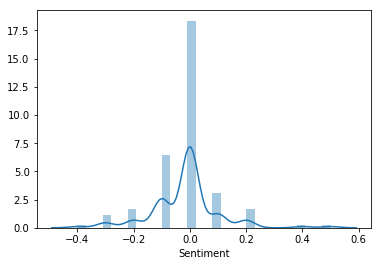

In [283]:
### Using another sentiment analyzer, Google's Sentiment Analyzer, yields slightly better results in terms of distribution, 
### as seen below, but it is still heavily skewed towards zero, as shown.

def get_sentiment_score(tweet):
    client = language.LanguageServiceClient()
    document = types\
               .Document(content=tweet,
                         type=enums.Document.Type.PLAIN_TEXT)
    sentiment_score = client\
                      .analyze_sentiment(document=document)\
                      .document_sentiment\
                      .score
    return sentiment_score


com_ds = pd.read_excel('Apple2_infosheet.xlsx', index_col=0)
pure_com = com_ds.dropna(axis=0)
sentiment_col = pure_com['Full'].apply(get_sentiment_score)
pure_com['Sentiment'] = sentiment_col




sns.distplot(pure_com['Sentiment'], bins=30)

In [284]:
av_senti_col = []
ud_col = []

### Finding average sentiment for each day ###
for ud in pure_com['Date'].unique():
    print(ud)
    av_senti = pure_com[pure_com['Date'] == ud]['Sentiment'].mean()
    av_senti_col.append(av_senti)
    ud_col.append(ud)

new_bt_com = pd.DataFrame({'Date':ud_col,'Average Sentiment':av_senti_col})

2019-09-26T00:00:00.000000000
2019-09-25T00:00:00.000000000
2019-09-24T00:00:00.000000000
2019-09-23T00:00:00.000000000
2019-09-21T00:00:00.000000000
2019-09-20T00:00:00.000000000
2019-09-19T00:00:00.000000000
2019-09-18T00:00:00.000000000
2019-09-17T00:00:00.000000000
2019-09-16T00:00:00.000000000
2019-09-15T00:00:00.000000000
2019-09-14T00:00:00.000000000
2019-09-13T00:00:00.000000000
2019-09-12T00:00:00.000000000
2019-09-11T00:00:00.000000000
2019-09-10T00:00:00.000000000
2019-09-09T00:00:00.000000000
2019-09-08T00:00:00.000000000
2019-09-07T00:00:00.000000000
2019-09-06T00:00:00.000000000
2019-09-05T00:00:00.000000000


In [285]:
### Once again, there is a poor linear correlation. This goes against our intution, which is that the market will follow
### human sentiments. An explanation for this phenomenon is described below.

def TrueFalse(a):
    if a:
        return 1
    else:
        return 0

stonks['Open/Close Difference'] = stonks['Close/Last'] - stonks['Open']
stonks['High/Low Difference'] = stonks['High'] - stonks['Low']
Comparison = pd.DataFrame({'Present': stonks['Close/Last'], 'Past':stonks['Close/Last'].shift(-1)})
truthy = Comparison['Present'] > Comparison['Past']
stonks['Up/Down'] = truthy.apply(TrueFalse)


stonks.head()



intersect_dates = [date for date in pure_com['Date'].unique() if date in stonks['Date'].unique() and date in new_bt_com['Date'].unique()]
print(intersect_dates)

date_index_com = new_bt_com.set_index('Date')
dately_sentiment = date_index_com.loc[intersect_dates,:]

date_index_stonks = stonks.set_index('Date')
dately_stonks = date_index_stonks.loc[intersect_dates, :]

comparison = pd.DataFrame({'Average Sentiment':dately_sentiment['Average Sentiment'].shift(-1), 
                           'Open/Close Difference':dately_stonks['Open/Close Difference'],
                          'High/Low Difference':dately_stonks['High/Low Difference'],
                         })

comparison.corr()

[numpy.datetime64('2019-09-23T00:00:00.000000000'), numpy.datetime64('2019-09-20T00:00:00.000000000'), numpy.datetime64('2019-09-19T00:00:00.000000000'), numpy.datetime64('2019-09-18T00:00:00.000000000'), numpy.datetime64('2019-09-17T00:00:00.000000000'), numpy.datetime64('2019-09-16T00:00:00.000000000'), numpy.datetime64('2019-09-13T00:00:00.000000000'), numpy.datetime64('2019-09-12T00:00:00.000000000'), numpy.datetime64('2019-09-11T00:00:00.000000000'), numpy.datetime64('2019-09-10T00:00:00.000000000'), numpy.datetime64('2019-09-09T00:00:00.000000000'), numpy.datetime64('2019-09-06T00:00:00.000000000'), numpy.datetime64('2019-09-05T00:00:00.000000000')]


,Average Sentiment,Open/Close Difference,High/Low Difference
Average Sentiment,1.000000,-0.338451,-0.179891
Open/Close Difference,-0.338451,1.000000,0.151997
High/Low Difference,-0.179891,0.151997,1.000000


In [ ]:
### Conclusion ###

### From the experiments done above, news sentiments do not seem to be very good indicators for predicting the daily movements
### of stock prices. Of course, the results are not fully conclusive as the sample size is quite small. However, in hindsight,
### there are several key reasons that point towards sentiment analysis being unhelpful:

### 1. High instance of noise - Even on news sites dedicated to business, you will often find articles that do not really
### add any information to the day-to-day change in investor sentiments. Eg. 'Apple just changed how you delete apps on 
### the iPhone — here’s the trick'. This is also because on many days, there is a lack of any important information that 
### may affect change to stock prices. In Twitter feeds, it can be seen that there are nowadays many documents that
### are repeats/useless for analyzing.

### 2. Inaccuracy of sentiment analyzer - As seen above, when analyzing documents sentiment analyzers can give highly
### inaccurate results as to the overall sentiment of the article. This is likely due to the simplistic model used in the 
### analyzer - simply matching positive and negative words in the article. This may be sufficient for movie 
### reviews, but for financial journalistic writing, it lacks the ability to understand nuance in context
### and also lacks the lexicon for the financial sector, eg. 'bullish' and 'bearish' are recognised as neutral terms. 
### Thus, misclassification happens often, leading to more inaccuracy. 

### 3. Small scope of search - Here, we are only looking for articles related to 'Apple' on certain days. But the biggest
### reasons for stock movements often are not directly related to the company itself, and thus are not reported. For instance,
### news of the possible impeachment of President Trump caused the Apple stock (along with the rest of the US market) to
### crash, despite the lack of any other negative news from Apple. One might suggest to just aggregate other related search
### terms, but the market is a complicated beast, with many seemingly unrelated factors that may affect a stock (eg. the 
### attack on Saudi oil facilities also caused a crash). For a machine to be able to effectively capture all this, it would
### need to dynamically recognise and understand links between different subjects, which still cannot be done reliably. 

### 4. Other reasons - For example that news is usually reactive and not predictive, news is written by humans with
### human fallacies etc.

### In conclusion, the experiments and reasons above corroborate the inadequacy of purely using sentiment analysis for 
### stock market prediction. This is why, despite the famous 'Twitter mood predicts the stock market' study, most firms
### do not utilise sentiments in their trading systems, and those that do are largely unsuccessful. (eg. the firm that
### opened immediately after the famous study and closed within a year) In the next section, we will take a look at 
### technical indicators, which are actually used by many successful trading systems. 


In [ ]:
### Note: I could have created a regression model to show poor predictive power using just sentiments, but I have omitted it
### so as not to extend this already overbloated section. I also tried gathering tweets using the Twitter API (and tweepy). 
### However, the API only allows you to gather tweets from 1 week ago, and the tweets I gathered generally had a lot of 
### noise and faced the same problem of misclassification as above. So I left it out as well.

<h1>Section 2: Technical Indicators</h1>
<p>Seeing as using sentiment analysis was not particularly effective, we will try our hand at using technical indicators to predict stock market prices instead. For simplicity's sake, I will only be evaluating relatively simple technical indicators, such as simple moving average, exponential moving average, ARIMA, and a LSTM.</p>

In [115]:
import tensorflow as tf

In [71]:
### Due to small size of webscraped dataset, I will be using the historical 2012-2016 data for this section instead.

import pandas as pd
from datetime import datetime


def date_parse(date):
    temp = date.split(' ')
    if '/' in date:
        return datetime.strptime(temp[0], "%d/%B/%Y")
    elif '-' in date:
        return datetime.strptime(temp[0], "%Y-%m-%d")

def pos_or_neg(net_change):
    if net_change >= 0:
        return 1
    else:
        return 0
ds = pd.read_csv(r'C:\Programming\nyse\prices.csv', parse_dates=[0], date_parser=date_parse)

In [353]:
print(ds.head(10))
print()
print("All unique companies in this dataset are:")
print(ds['symbol'].unique())
print()
print("Number of unique companies is {}".format(len(ds['symbol'].unique()))) #How many companies?
print()
ds.info() #No null items to clean up

        date symbol        open       close         low        high  \
0 2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1 2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2 2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3 2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4 2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   
5 2016-01-12   WLTW  115.510002  115.550003  114.500000  116.059998   
6 2016-01-13   WLTW  116.459999  112.849998  112.589996  117.070000   
7 2016-01-14   WLTW  113.510002  114.379997  110.050003  115.029999   
8 2016-01-15   WLTW  113.330002  112.529999  111.919998  114.879997   
9 2016-01-19   WLTW  113.660004  110.379997  109.870003  115.870003   

      volume  10 Day EMA  40 Day EMA  
0  2163600.0  125.839996  125.839996  
1  2386400.0  122.770476  122.873827  
2  2489500.0  119.911630  120.167068  
3  2006300.0  118.967619  119.247192  
4  1408600.0  118.00892

In [393]:
### We will be using prices for Apple only for demonstration purposes

apple = ds[ds['symbol'] == 'AAPL']
y_vals = apple['close'].as_matrix()


C:\Users\Edison Siow Xiong\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


C:\Users\Edison Siow Xiong\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Text(0, 0.5, 'Stock Price ($US)')

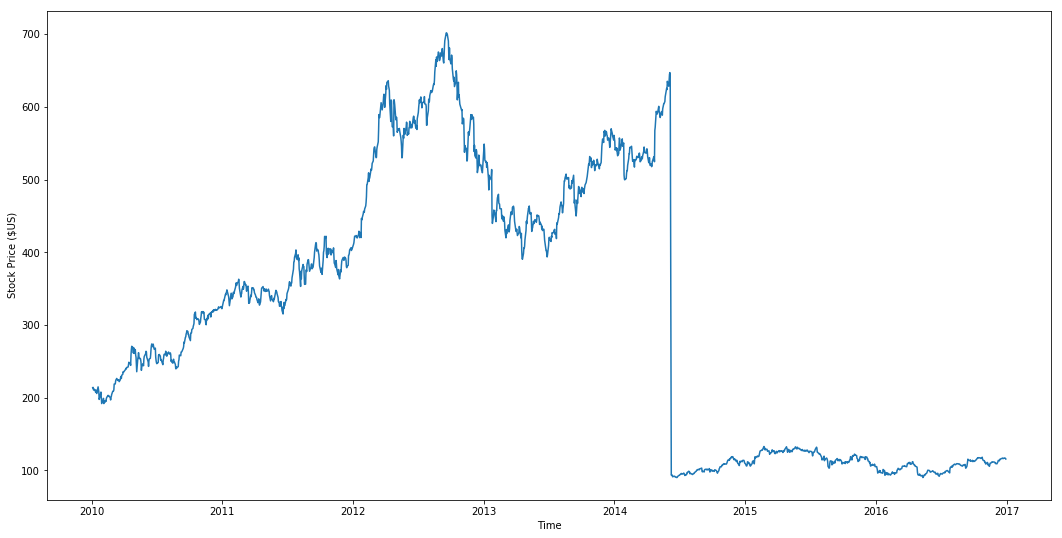

In [394]:
plt.figure(figsize=(18,9))
plt.plot(apple['date'].as_matrix(), y_vals)
plt.xlabel('Time')
plt.ylabel('Stock Price ($US)')

In [395]:
### Defining train/test sets, and scaling for greater accuracy

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_data = y_vals[:1200]
test_data =y_vals[1200:]

train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)
scaler.fit(train_data)
train_data = scaler.transform(train_data).reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)


In [396]:
### Evaluating a 40 day simple moving average model ###

window_size = 40
N = test_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = ds.loc[pred_idx,'date']

    std_avg_predictions.append(np.mean(test_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-test_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00005


C:\Users\Edison Siow Xiong\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Edison Siow Xiong\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


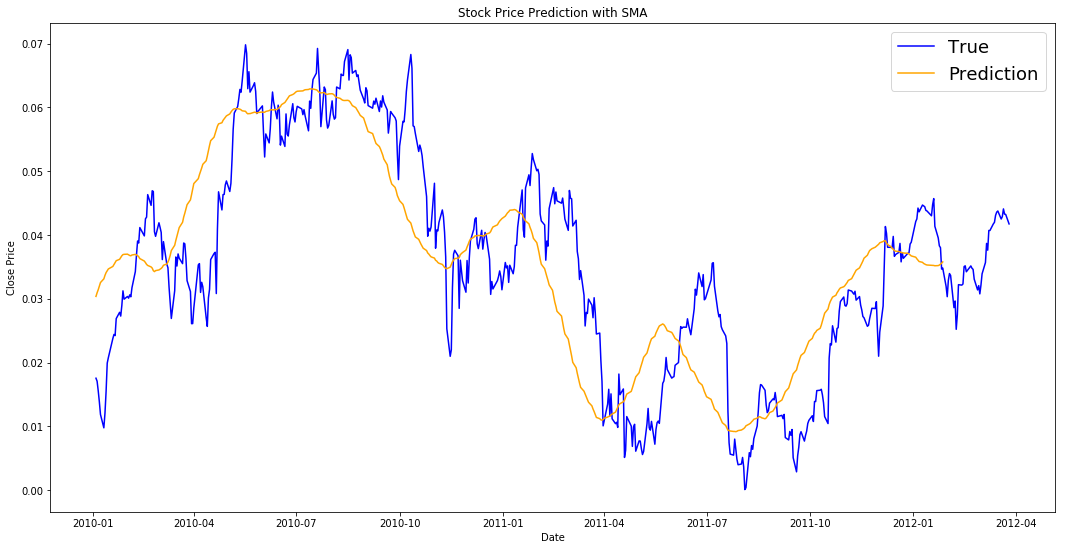

In [397]:
plt.figure(figsize=(18, 9))
plt.plot(apple['date'].as_matrix()[:N],test_data, color='b', label='True')
plt.plot((apple['date'].as_matrix()[:N-40]), std_avg_predictions, color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction with SMA')
plt.legend(fontsize=18)
plt.show()

In [357]:
### Evaluating a 40 day exponential moving average model ###
window_size = 40
N = test_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*test_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-test_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00001


C:\Users\Edison Siow Xiong\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Edison Siow Xiong\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


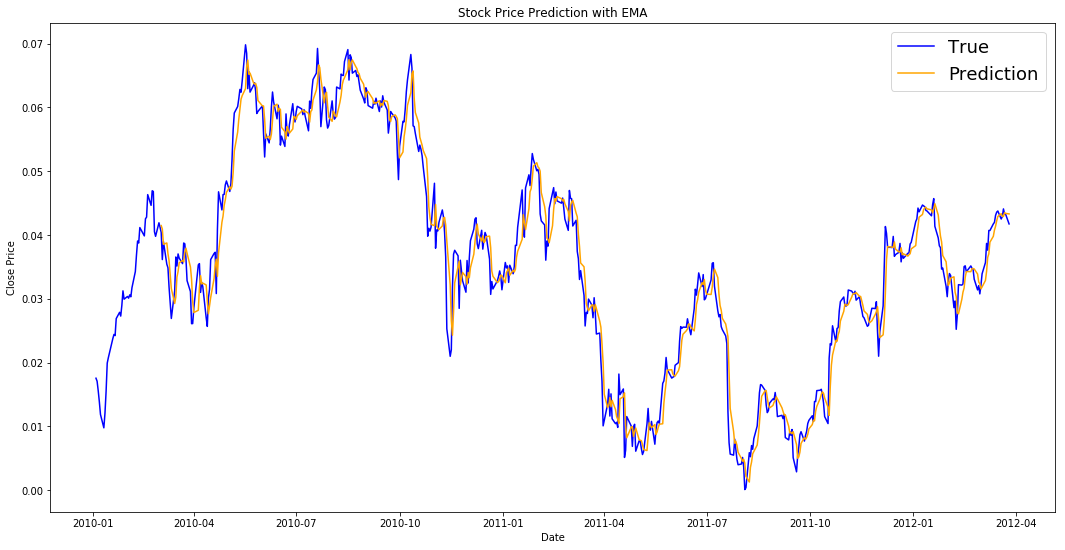

In [358]:
plt.figure(figsize = (18,9))
plt.plot(apple['date'].as_matrix()[:N],test_data,color='b',label='True')
plt.plot(apple['date'].as_matrix()[40:N], run_avg_predictions[40:],color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction with EMA')
plt.legend(fontsize=18)
plt.show()

Test MSE: 0.000


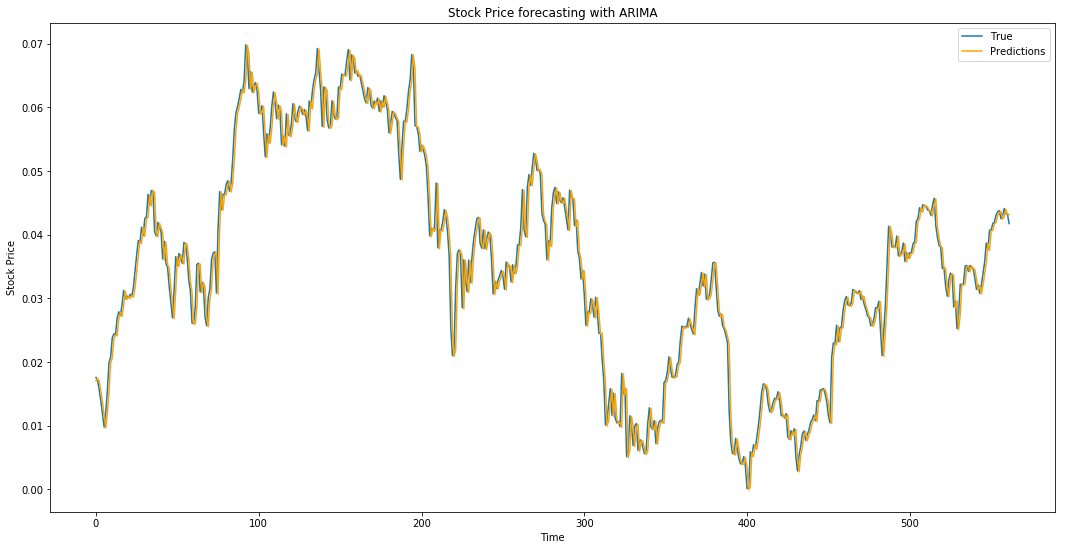

In [359]:
### ARIMA with a 1 day lag###
### Code used with modification from https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/ ###

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = y_vals
size = int(len(X) * 0.66)
train, test = train_data, test_data
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.figure(figsize = (18,9))
plt.plot(test, label='True')
plt.plot(predictions, color='orange', label='Predictions')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price forecasting with ARIMA')
plt.show()

In [ ]:
### From results, it seems that using the EMA and ARIMA are much more accurate than using SMA, and the former two produce 
### results with low MSE, suggesting that they should be useful in predicting future stock prices. 

In [122]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [ ]:
### Using a LSTM Neural Network with information on the past 60 days of stock prices

In [150]:
dataset_train = ds[ds['symbol'] == 'AAPL'][:1200]
training_set = apple[['close']].values

In [151]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [152]:
X_train = []
y_train = []
for i in range(60, 1200):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [153]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1140/1140 [==============================] - 6s 5ms/step - loss: 0.0511
Epoch 2/100
1140/1140 [==============================] - 6s 5ms/step - loss: 0.0141
Epoch 3/100
1140/1140 [==============================] - 6s 5ms/step - loss: 0.0126
Epoch 4/100
1140/1140 [==============================] - 6s 6ms/step - loss: 0.0120
Epoch 5/100
1140/1140 [==============================] - 6s 6ms/step - loss: 0.0100
Epoch 6/100
1140/1140 [==============================] - 7s 6ms/step - loss: 0.0092
Epoch 7/100
1140/1140 [==============================] - 7s 6ms/step - loss: 0.0099
Epoch 8/100
1140/1140 [==============================] - 6s 5ms/step - loss: 0.0079
Epoch 9/100
1140/1140 [==============================] - 6s 5ms/step - loss: 0.0081
Epoch 10/100
1140/1140 [==============================] - 6s 5ms/step - loss: 0.0077
Epoch 11/100
1140/1140 [==============================] - 6s 5ms/step - loss: 0.0072
Epoch 12/100
1140/1140 [==============================] - 6s 5ms/step - lo

In [155]:
dataset_test  = ds[ds['symbol'] == 'AAPL'][1200:]
real_stock_price = dataset_test[['close']].values

In [170]:
### Used with modification from https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html

dataset_total = pd.concat((dataset_train['close'], dataset_test['close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)

inputs = sc.transform(inputs)

X_test = []
for i in range(60, 620):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

The MSE of the LSTM Neural Network is 33.97914960344168


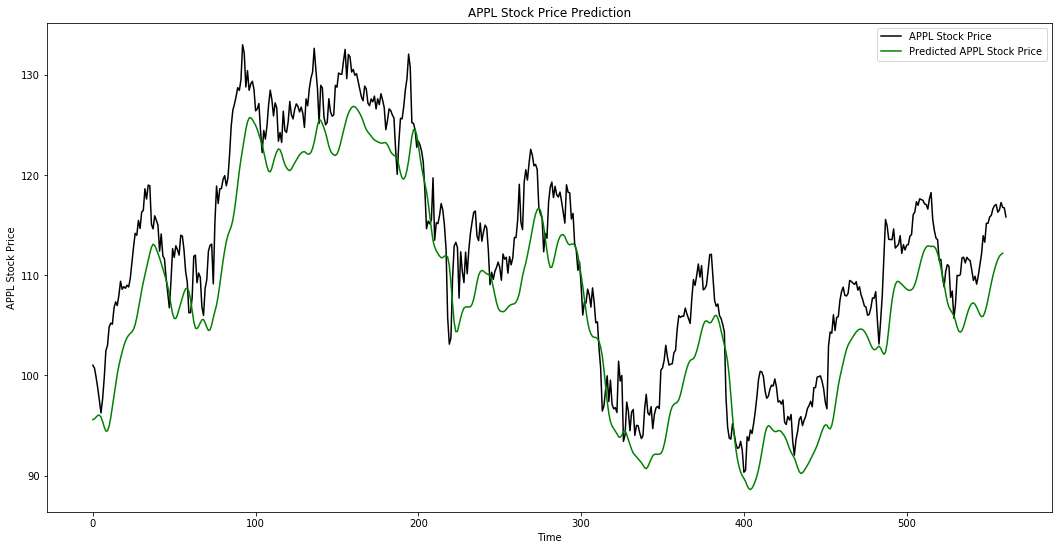

In [286]:

plt.figure(figsize = (18,9))
plt.plot(real_stock_price, color = 'black', label = 'APPL Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted APPL Stock Price')
plt.title('APPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('APPL Stock Price')
error = mean_squared_error(real_stock_price[2:], predicted_stock_price)
print("The MSE of the LSTM Neural Network is {}".format(error))
plt.legend()
plt.show()

In [ ]:
### Conclusion ###
### From results, it seems that technical indicators are far more useful in predicting price movements as compared to 
### sentiment analysis. In particular, it seems that EMAs and ARIMA is far more useful than SMAs and even a LSTM network at
### prediction. Thus, my suggestion would be to utilise EMA/ARIMA in automated trading systems. 

### It is suprising that the LSTM network did not do so well, considering it is more complex than EMAs (which
### basically boil down to calculations that humans could do manually) and can recognise long-term patterns. Well it achieved
### that general goal, but predicted prices consistently lower than the actual. Since much of the LSTM is a black box,
### I cannot say for certain, but it is possible that a quirk of this model caused it to predict prices consistently lower,
### yet it still had the lowest MSE of all the epochs. Considering such idiosyncracies, I would consider EMA/ARIMA as 
### a much more reliable predictor. 

<h1>Section 3: Using Neural Networks to simulate a trading environment</h1>
<p>Now that we have confirmed the supremacy of technical indicators in predicting prices, we will try to put it to use for
    an AI in a simulated trading environment. In this environment, there are 3 possible stocks for the 
    AI to choose from, and it is given information about how much money it has, the stock prices, the stock it owns, and the 10 day and 40 day exponential moving averages of the 3 stocks. Using reinforcement learning, its goal is to earn as much money as possible, via the 3 possible actions of buying, holding, or selling stock.</p>
    
 <p> Code here used with modifications from https://github.com/llSourcell/Q-Learning-for-Trading (eg.
integrating the EMAs into the model)<p>

In [216]:
### Model ###

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam



def mlp(n_obs, n_action, n_hidden_layer=1, n_neuron_per_layer=32,
        activation='relu', loss='mse'):
    """ A multi-layer perceptron """
    print('n_obs is {}'.format(n_obs))

    model = Sequential()
    
    model.add(Dense(n_neuron_per_layer, input_dim=n_obs, activation=activation))
    for _ in range(n_hidden_layer):
        model.add(Dense(n_neuron_per_layer, activation=activation))
    model.add(Dense(n_action, activation='linear'))
    model.compile(loss=loss, optimizer=Adam())
    print(model.summary())
 
    return model


In [338]:
from collections import deque
import random
import numpy as np

### AGENT ###


class DQNAgent(object):
  """ A simple Deep Q agent """
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=2000)
    self.gamma = 0.95  # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = mlp(state_size, action_size)


  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))


  def act(self, state):
    if variation and np.random.rand() <= self.epsilon:
      return random.randrange(self.action_size)
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])  # returns action


  def replay(self, batch_size=32):
    """ vectorized implementation; 30x speed up compared with for loop """
    minibatch = random.sample(self.memory, batch_size)
 
    states = np.array([tup[0][0] for tup in minibatch])
    actions = np.array([tup[1] for tup in minibatch])
    rewards = np.array([tup[2] for tup in minibatch])
    next_states = np.array([tup[3][0] for tup in minibatch])
    done = np.array([tup[4] for tup in minibatch])

    # Q(s', a)
    target = rewards + self.gamma * np.amax(self.model.predict(next_states), axis=1)
    # end state target is reward itself (no lookahead)
    target[done] = rewards[done]

    # Q(s, a)
    target_f = self.model.predict(states)
    # make the agent to approximately map the current state to future discounted reward
    target_f[range(batch_size), actions] = target

    self.model.fit(states, target_f, epochs=1, verbose=0)

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay


  def load(self, name):
    self.model.load_weights(name)


  def save(self, name):
    self.model.save_weights(name)

In [388]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

### UTILITY FUNCTIONS ###
### YHOO, EBAY, NKE

def get_data(col='close'):
  """ Returns a 3 x n_step array """
  msft = ds[ds['symbol'] == 'AAPL']
  ibm = ds[ds['symbol'] == 'GOOGL']
  qcom =ds[ds['symbol'] == 'FDX']
  # recent price are at top; reverse it
  return np.array([msft[col],
                   ibm[col],
                   qcom[col]])

def fifteen_day_ma(col='10 Day EMA'):
  """ Returns a 3 x n_step array """
  msft = ds[ds['symbol'] == 'AAPL']
  ibm = ds[ds['symbol'] == 'GOOGL']
  qcom =ds[ds['symbol'] == 'FDX']
  # recent price are at top; reverse it
  return np.array([msft[col],
                   ibm[col],
                   qcom[col]])

def forty_day_ma_creation(col='40 Day EMA'):
  """ Returns a 3 x n_step array """
  msft = ds[ds['symbol'] == 'AAPL']
  ibm = ds[ds['symbol'] == 'GOOGL']
  qcom =ds[ds['symbol'] == 'FDX']
  # recent price are at top; reverse it
  return np.array([msft[col],
                   ibm[col],
                   qcom[col]])



def get_scaler(env):
  """ Takes a env and returns a scaler for its observation space """
  low = [0] * (env.n_stock * 2 + env.n_15ma + env.n_40ma + 1)

  high = []
  max_price = env.stock_price_history.max(axis=1)
  min_price = env.stock_price_history.min(axis=1)
  max_15ma = env.fif_day_ma_history.max(axis=1)
  min_15ma = env.fif_day_ma_history.min(axis=1)
  max_40ma = env.forty_day_ma_history.max(axis=1)
    
  max_cash = env.init_invest * 3 # 3 is a magic number...
  max_stock_owned = max_cash // min_price
  for i in max_stock_owned:
    high.append(i)
  for i in max_price:
    high.append(i)
  for i in max_15ma:
    high.append(i)
  for i in max_40ma:
    high.append(i)
  high.append(max_cash)


    



  scaler = StandardScaler()
  scaler.fit([low, high])
  return scaler


def maybe_make_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)

In [339]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import itertools


## ENVIRONMENT BUILDER ###

class TradingEnv(gym.Env):
  """
  A 3-stock (MSFT, IBM, QCOM) trading environment.
  State: [# of stock owned, current stock prices, cash in hand]
    - array of length n_stock * 2 + 1
    - price is discretized (to integer) to reduce state space
    - use close price for each stock
    - cash in hand is evaluated at each step based on action performed
  Action: sell (0), hold (1), and buy (2)
    - when selling, sell all the shares
    - when buying, buy as many as cash in hand allows
    - if buying multiple stock, equally distribute cash in hand and then utilize the balance
  """
  def __init__(self, train_data, fif_day_ma, forty_day_ma, init_invest=20000):
    # data
  
    self.fif_day_ma_history = np.around(fif_day_ma)
    self.n_15ma, self.n_step = self.fif_day_ma_history.shape
    
    self.forty_day_ma_history = np.around(forty_day_ma)
    self.n_40ma, self.n_step = self.forty_day_ma_history.shape
    
    
    self.stock_price_history = np.around(train_data) # round up to integer to reduce state space
    self.n_stock, self.n_step = self.stock_price_history.shape
    
 
    
    # instance attributes
    self.init_invest = init_invest
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cur_15ma = None
    self.cur_40ma = None
    self.cash_in_hand = None

    # action space
    self.action_space = spaces.Discrete(3**self.n_stock)

    # observation space: give estimates in order to sample and build scaler
    stock_max_price = self.stock_price_history.max(axis=1)
    stock_range = [[1, init_invest * 2 // mx] for mx in stock_max_price]
    
    price_range = [[1, mx] for mx in stock_max_price]
    
    cash_in_hand_range = [[1, init_invest * 2]]
    
    max_15ma = self.fif_day_ma_history.max(axis=1)
    fif_ma_range = [[1, mx] for mx in max_15ma]
    
    max_40ma = self.forty_day_ma_history.max(axis=1)
    forty_ma_range = [[1, mx] for mx in max_40ma]
    
    self.observation_space = spaces.MultiDiscrete(stock_range + price_range + fif_ma_range + forty_ma_range + cash_in_hand_range )
    


    # seed and start
    self._seed()
    self._reset()


  def _seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]


  def _reset(self):
    self.cur_step = 0
    self.stock_owned = [0] * self.n_stock
    self.stock_price = self.stock_price_history[:, self.cur_step]
    self.cash_in_hand = self.init_invest
    self.cur_15ma = self.fif_day_ma_history[:, self.cur_step]
    self.cur_40ma = self.fif_day_ma_history[:, self.cur_step]
    return self._get_obs()


  def _step(self, action):
    assert self.action_space.contains(action)
    prev_val = self._get_val()
    self.cur_step += 1
    self.stock_price = self.stock_price_history[:, self.cur_step] # update price
    self._trade(action)
    cur_val = self._get_val()
    reward = cur_val - prev_val
    done = self.cur_step == self.n_step - 1
    info = {'cur_val': cur_val}
    return self._get_obs(), reward, done, info


  def _get_obs(self):
    obs = []
    obs.extend(self.stock_owned)
    obs.extend(list(self.stock_price))
    obs.append(self.cash_in_hand)
    obs.extend(list(self.cur_15ma))
    obs.extend(list(self.cur_40ma))
    return obs


  def _get_val(self):
    return np.sum(self.stock_owned * self.stock_price) + self.cash_in_hand


  def _trade(self, action):
    # all combo to sell(0), hold(1), or buy(2) stocks
    action_combo = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

    action_vec = action_combo[action]

    # one pass to get sell/buy index
    sell_index = []
    buy_index = []
    for i, a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)

    # two passes: sell first, then buy; might be naive in real-world settings
    if sell_index:
      for i in sell_index:
        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
        self.stock_owned[i] = 0
    if buy_index:
      can_buy = True
      while can_buy:
        for i in buy_index:
          if self.cash_in_hand > self.stock_price[i]:
            self.stock_owned[i] += 1 # buy one share
            self.cash_in_hand -= self.stock_price[i]
          else:
            can_buy = False

In [207]:
### Adding the 10 day and 40 day EMA as parameters

ds['10 Day EMA'] = ds['close'].ewm(10).mean()
ds['40 Day EMA'] = ds['close'].ewm(40).mean()

ds.head(20)

,date,symbol,open,close,low,high,volume,10 Day EMA,40 Day EMA
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,125.839996,125.839996
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,122.770476,122.873827
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,119.911630,120.167068
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,118.967619,119.247192
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,118.008927,118.348995
5,2016-01-12,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0,117.495666,117.853232
6,2016-01-13,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0,116.628170,117.084465
7,2016-01-14,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0,116.245073,116.716479
8,2016-01-15,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0,115.658630,116.204067
9,2016-01-19,WLTW,113.660004,110.379997,109.870003,115.870003,1523500.0,114.877654,115.554846


In [ ]:
### Here, our environments and models are all set up, so we can begin training. We train the model using 1200 days
### of stock prices from three companies: Apple, Google and FDX, and modify the weights using a batch size of 32. 
### Finally, after 2000 episodes (epochs), we save a set of weights for the neural network that we can use in the future. 
### 
### 
### After that, we test our model using a test set of the next 562 days (about 1.5 years) for the same 3 companies. 
### The model, having never seen this information before, has to make decisions of buying/holding/selling 
### using only previous days' prices and EMAs. Let's see how it performs. For the test instance, I have turned off 
### variation (exploration) so that there is definitive evaluation on the effectiveness of these weights.

In [389]:
import pickle
import time
import numpy as np
import argparse
import re

### Model Training and Testing ###

if __name__ == '__main__':
 
    episode, batch_size, initial_invest, mode, weights, variation  = 2000, 32, 20000, 'test', './weights/201909261401-dqn.h5', False

    maybe_make_dir('weights')
    maybe_make_dir('portfolio_val')

    timestamp = time.strftime('%Y%m%d%H%M')

    data = np.around(get_data())
    print(data.shape)
    train_data = data[:,:1200]
    test_data = data[:,1200:]
    
    fif_day_ma = np.around(fifteen_day_ma())
    train_fif_day_ma = fif_day_ma[:,:1200]
    test_fif_day_ma = fif_day_ma[:,1200:]
    
    forty_day_ma = np.around(forty_day_ma_creation())
    train_forty_day_ma = forty_day_ma[:,:1200]
    test_forty_day_ma = forty_day_ma[:,1200:]
    
    env = TradingEnv(train_data,train_fif_day_ma, train_forty_day_ma , initial_invest)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    scaler = get_scaler(env)
    
    start_portfolio_value = []
    portfolio_value = []
    equity_history = []
    
    
    if mode == 'test':
        print('here')
        # remake the env with test data
        env = TradingEnv(test_data, test_fif_day_ma, test_forty_day_ma , initial_invest)
        # load trained weights
        agent.load(weights)
        # when test, the timestamp is same as time when weights was trained
        timestamp = re.findall(r'\d{12}', weights)[0]
      



    for e in range(episode):
        state = env._reset()

        state = scaler.transform([state])
        for time in range(env.n_step):
            action = agent.act(state)
            
            next_state, reward, done, info = env._step(action)
            next_state = scaler.transform([next_state])
            if mode == 'test':
                equity_history.append(env._get_val())
            if mode == 'train':
                agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                print("episode: {}/{}, episode end value: {}".format(
                  e + 1, episode, info['cur_val']))
                
           
                
                portfolio_value.append(info['cur_val']) # append episode end portfolio value
                break

            if mode == 'train' and len(agent.memory) > batch_size:
                agent.replay(batch_size)
        
        if mode == 'train' and (e + 1) % 10 == 0:  # checkpoint weights
            agent.save('weights/{}-dqn.h5'.format(timestamp))

      # save portfolio value history to disk
    if variation:
        with open('portfolio_val/{}-{}.p'.format(timestamp, mode), 'wb') as fp:
            pickle.dump(portfolio_value, fp)
    if mode =='test':
        with open('equity_history/{}-{}.p'.format(timestamp, mode), 'wb') as fp:
            pickle.dump(equity_history, fp)


(3, 1762)
n_obs is 13
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_206 (Dense)            (None, 32)                448       
_________________________________________________________________
dense_207 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_208 (Dense)            (None, 27)                891       
Total params: 2,395
Trainable params: 2,395
Non-trainable params: 0
_________________________________________________________________
None
here
episode: 1/1, episode end value: 23999.0


In [ ]:
### A value of 24000 is obtained, which represents a 20% increase over 1.5 years. Not too bad for a machine! 
### What if we had allowed for some exploration though? Obviously, the machine would perform differently, but 
### would it's average performance outperform what we currently have? 

In [ ]:
### Below we have a file containing the final portfolio prices run with the model with the same weights 500 times on the 
### test set with variation allowed. The testing is not shown since I don't want to copy the code again, 
### but take for granted that it has been done.

In [384]:
from statistics import mean 
first_test = open(r'./portfolio_val/201909261401-test.p', 'rb')
new_file = pickle.load(first_test, encoding='bytes|')
print(len(new_file))
mean((new_file))

500


24578.422

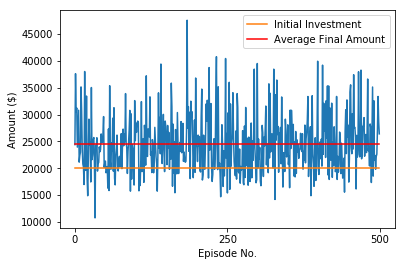

In [381]:
plt.plot(list(map(str, range(1,501))), new_file)
plt.plot(list(map(str, range(1,501))), [20000 for _ in range(500)], label='Initial Investment')
plt.plot(list(map(str, range(1,501))), [mean((new_file)) for _ in range(500)], color='red', label='Average Final Amount')
plt.xticks([0, 250, 500],(('0', '250','500')))
plt.ylabel('Amount ($)')
plt.xlabel('Episode No.')
plt.legend()
plt.show()

In [ ]:
### Overall, there are some variations of the model that perform better than the one we have, and some that perform worse, 
### although on average the models perform slightly better, and they rarely lose money on the initial investment. 

In [ ]:
### How does the model perform on stocks that are not the above 3 (Apple, Google, FDX), though? Let's find out. In their 
### stead, we will use NKE, EBAY, and YHOO (Nike, Ebay, Yahoo). 
###
### Fun fact: The Yahoo stock ticker YHOO was discontinued in 2016 after it crashed and was acquired by Verizon. However,
### from its remains, a new investment company called Altbaba was created with the symbol AABA. Guess where they got 
### that from?

In [385]:
sec_test = open(r'./portfolio_val/201909261401-test-others.p', 'rb')
new_file = pickle.load(sec_test, encoding='bytes|')
print(len(new_file))
mean((new_file))

500


17178.662

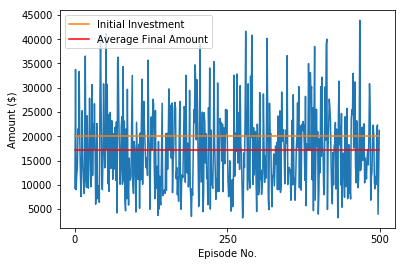

In [386]:
plt.plot(list(map(str, range(1,501))), new_file)
plt.plot(list(map(str, range(1,501))), [20000 for _ in range(500)], label='Initial Investment')
plt.plot(list(map(str, range(1,501))), [mean((new_file)) for _ in range(500)], color='red', label='Average Final Amount')
plt.xticks([0, 250, 500],(('0', '250','500')))
plt.ylabel('Amount ($)')
plt.xlabel('Episode No.')
plt.legend()
plt.show()

In [ ]:
### Note: for a model wihtout variation, it gives 19502.0 after testing.

In [ ]:
### Conclusion ###
### This experiment shows the great potential of neural networks to be used in automated trading systems, especially with 
### powerful technical indicators such as Exponential Moving Averages to help guide the training process. However, one 
### needs to be cautious when using the model outside a market that it has not not been trained on, as it could lead 
### to financial ruin.

In [398]:
### Possible Future Extensions to this project ###
### Right now I have only evaluated the usefulness of a few technical indicators aka SMA, EMA, ARIMA, LSTM. However, many
### more such as the MACD, Stochastic KD, Larry William's R%, as well as some fundamental analysis should also be evaluated
### on their usefulness. 

### Currently, my results find sentiment analysis to be unhelful, though I admit my methodology as a beginner is likely
### flawed. Other studies using a more specialised analyzer, larger test set, and perhaps more breaking news will find 
### a better correlation.

### The neural network used in reinforcement learning is a rather typical one...other types of neural networks (such as LSTM)
### could be used to compare their effectiveness. There may also be a comparison done between trading 1 stock only and
### many stocks, to see whether the adage of 'always diversify' also holds true for machines.  


<h1>Executive Summary</h1>
<p>This project aimed to discover the effectiveness and feasibility of using sentiment analysis, technical indicators, and
neural networks to predict stock price movements and for automated trading. The hypotheses were that Sentiment analysis 
and technical indicators would both be essential in predicting price movements, with sentiment analysis playing a larger role 
since the market is driven by investor sentiments. It was predicted that neural networks would also be effective in 
prediction and trading. For sentiment analysis, webscraped articles from financial news sites were scraped and used to drive 
sentiment analysis. The financial data used was scraped from NASDAQ website due to lack of recent financial datasets.
Technical indicators were calculated using mathematics and popular libaries such as TensorFlow and Keras. The dataset used
here was historical prices from the NYSE from 2012 to 2016, particularly AAPL. A simple neural network the underwent 
reinforcement learning in a simulated trading environment with EMAs provided as parameters, in order to teach it to generate
profits. </p>
    
<p>Surprisngly, the results found that sentiment analysis was the least beneficial to predicting prices, due to
abundance of noise and unsuitability of the analyzer, contradicting the original hypothesis. Several technical indicators
were tested and the most accurate was found to be the exponential moving average (EMA) and AutoRegressive Integrated
Moving Average (ARIMA). Finally, after training a model using reinforcement learning, the conclusion is that neural
networks are effective in generating profit after some training, confirming my hypothesis on this account. Possible 
discussion points and extensions of this project may be the need to develop a more specialised sentiment analyzer for
financial documents, and studies comparing the effectiveness of other technical indicators and neural networks in 
comparison to those used here.</p>
    


# Comments

**Score (Out of 20):** 20

**Legend:**

- (+) What I liked
- (/) Note
- (-) Suggestion for Improvement

**Grading**

- Dataset evaluation (Out of 5) - 5
    - (+) Explored many variables available in the data set
    - (+) Variables were visualized appriopriately
    - (+) Explored web scraping extensively

- Methodology (Out of 10)- 10

    - (+) Cleaned data using drop, dropna, renamed columns, filtering
    - (+) Proper usage of train test split, fit, model
    - (+) Excellent use of simulation for financial data

- Insights / evaluation (Out of 5) - 5
    - (+) Compared pros and cons of each model
    - (+) Put in thought into analyzing the data set, attempted various models